<a href="https://colab.research.google.com/github/vorst4/TUE_5LSM0_g6/blob/master/TUE_5LSM0_g6_dennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# ------------------------------ Import modules ------------------------------ #

import os
import json
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from glob import glob
from datetime import datetime
from PIL import Image
from google.colab import drive

# ---------------------- Import modules from Git source ---------------------- #

# efficient net (downloaded from Git)
try:
  from EfficientNet.efficientnet_pytorch.model import EfficientNet
except:
  print('\nInstalling efficient-net...')
  !git clone https://github.com/lukemelas/EfficientNet-PyTorch
  os.rename('EfficientNet-PyTorch', 'EfficientNet')
  from EfficientNet.efficientnet_pytorch.model import EfficientNet
  print('Done')

# shap
try:
  import shap
except:
  print('\nInstalling shap...')
  !pip install shap
  import shap
  print('Done')

# # classification scores of isic challenge
# try:
#   from isic_challenge_scoring.isic_challenge_scoring.classification import ClassificationScore
# except:
#   print('\nInstalling isic-challenge-scoring...')
#   !git clone https://github.com/ImageMarkup/isic-challenge-scoring.git
#   os.rename('isic-challenge-scoring', 'isic_challenge_scoring')
#   from isic_challenge_scoring.isic_challenge_scoring.classification import ClassificationScore
#   print('Done')


# ----------------------------- Initialize Colab ----------------------------- #
#
# NOTE: all console commands (the ones that start with !) cannot be run from a 
# .py script. Usually this is possible using the command 'os.system('...')'.
# However, in Colab, it is for some reason not possible to obtain the console
# output of the command that is run. This makes it impossible to notify the user
# if an error occurs. All the commands therefore need to be run in the main
# .ipynb script (which is this script).
#


# check if GPU is enabled
if torch.cuda.is_available() == False:
  print('\nWARNING: GPU not enabled. Goto runtime -> change runtime type')


# mount Google Drive (if needed)
if not os.path.exists('drive'):
  print('\nMounting Google Drive...')
  drive.mount('/content/drive')
  print('Done')


# setup Git (if needed)
if not os.path.exists('TUE_5LSM0_g6'):
  print('\nSetting up git...')
  print('...Loading github.json from Google Drive')
  with open('/content/drive/My Drive/github.json', 'r') as json_file:
    gitconfig = json.load(json_file)
  print('...Cloning git repo')
  url = 'https://'+gitconfig["username"]+':'+gitconfig["key"]+\
        '@github.com/vorst4/TUE_5LSM0_g6.git'
  !git clone {url}
  print('...Setting username and email')
  !git -C TUE_5LSM0_g6 config user.name {gitconfig["username"]}
  !git -C TUE_5LSM0_g6 config user.email {gitconfig["email"]}
  print('Done')


# remove default sample_data folder (if needed)
if os.path.exists('sample_data'):
  print('\nRemoving sample_data...')
  os.system('rm -r sample_data')
  print('Done')


# copy and unzip data from Google Drive (if needed)
if not os.path.exists('ISIC_2019_Test_Input'):
  print('\nGetting data...')
  print('...Copying data.zip from Google Drive to workfolder')
  !cp 'drive/My Drive/5LSM0-final-assignment/data.zip' .
  print('...Unpacking data.zip')
  !unzip -q data.zip
  print('...Removing data.zip')
  !rm data.zip
  print('Done\n')


# ----------------------------- Import Functions ----------------------------- #
#
# NOTE: The modules need to be forcibly reloaded because Colab does not do this
# by default, even if the module has changed.
#

# dataloaders
import TUE_5LSM0_g6.dataloaders
importlib.reload(TUE_5LSM0_g6.dataloaders)
dataloaders = TUE_5LSM0_g6.dataloaders.dataloaders

# train & accuracy
import TUE_5LSM0_g6.train
importlib.reload(TUE_5LSM0_g6.train)
train = TUE_5LSM0_g6.train.train
accuracy = TUE_5LSM0_g6.train.accuracy

# resnet18
import TUE_5LSM0_g6.resnet18
importlib.reload(TUE_5LSM0_g6.resnet18)
resnet18 = TUE_5LSM0_g6.resnet18.resnet18

# backup
import TUE_5LSM0_g6.backup
importlib.reload(TUE_5LSM0_g6.backup)
backup = TUE_5LSM0_g6.backup.backup

# restore
import TUE_5LSM0_g6.restore
importlib.reload(TUE_5LSM0_g6.restore)
restore = TUE_5LSM0_g6.restore.restore


# --------------------------------- Constants -------------------------------- #

N_classes = 9

# --------------------------------- Settings --------------------------------- #

# settings object
S = type('settings', (), {})()

# use gpu/cpu
if torch.cuda.is_available():
  S.device = torch.device('cuda')
else:
  S.device = torch.device('cpu')

# image size (squared)
S.modelname = 'efficientnet-b0'
S.img_size = EfficientNet.get_image_size(S.modelname)

# set variable type
S.dtype = torch.float32

# when to print
S.print_every = 100

# number of epochs to run
S.epochs = 50

# batch size, increase this until the RAM is full
S.batch_size = 64

# percentage of original train set that is to be used for validation
S.val_ratio = 10

# restore last backup of model?
S.load_backup = True

# Create backup each epoch?
S.backup_each_epoch = True

# Create backup if training is finished?
S.backup_on_finish = False


# ----------------------------------- Main ----------------------------------- #

# create data loader objects for train, validation and test set.
dl_train, dl_val, dl_test = dataloaders(batch_size=S.batch_size,
                                        val_ratio = S.val_ratio,
                                        img_size = S.img_size)

# learning rate (with decay)
# todo: make a script that runs the model with different rates
learning_rate = 1e-3
decayRate = 0.9

# model
# model = resnet18(S.img_size)

# load pretrained efficientnet model (b0 is the smallest model). Note that img
# size must be 224 for model b0
if S.img_size == EfficientNet.get_image_size(S.modelname):
  model = EfficientNet.from_pretrained(S.modelname, N_classes)
  # model = EfficientNet.from_name(S.modelname, N_classes)


# load non-pretrained model (compare these two later on)
# model = EfficientNet.from_pretrained('efficientnet-b0')

# print layer sizes
# model.print_layer_sizes()


# load backup
if S.load_backup:
  model = restore(model, S.modelname)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# learning rate
lr_exp = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# train
# train(model, optimizer, dl_train, dl_val, lr_exp, S)

# visualize results
# model.visualize()

# save obtained model (not needed if it is already saved after each epoch)
if S.backup_on_finish and not S.backup_each_epoch:
  backup(model, S.modelname)

# # get accuracy best model
# best_model = model
# accuracy(dl_test, best_model)

# # create csv file of test data
# make_csv(best_model)


# ----------------------------------- End ------------------------------------ #


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/checkpoints/adv-efficientnet-b0-b64d5a18.pth



Loaded pretrained weights for efficientnet-b0

Restored model



In [0]:
# ------------------------- GIT Pull, Commit & Push -------------------------- #

def git():

  if not input('\nPull? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 pull

  commit_msg = '\''+input('\nEnter commit message: ')+'\''

  if not input('\nCommit? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 add .
  !git -C /content/TUE_5LSM0_g6 commit -m {commit_msg}

  if not input('\nPush? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 push

git()

# ----------------------------------- End ------------------------------------ #



Pull? (y)y
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/vorst4/TUE_5LSM0_g6
   fe9924b..b5ef4e2  master     -> origin/master
Updating fe9924b..b5ef4e2
Fast-forward
 TUE_5LSM0_g6_dennis.ipynb | 303 +++++++++++++++++++++++++++++++++++++++++-----
 1 file changed, 272 insertions(+), 31 deletions(-)

Enter commit message: small bugfix

Commit? (y)y
[master 8d18283] small bugfix
 1 file changed, 1 insertion(+), 1 deletion(-)

Push? (y)y
Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 292 bytes | 292.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/vorst4/TUE_5LSM0_g6.git
   b5ef4e2..8d18283  master -> maste

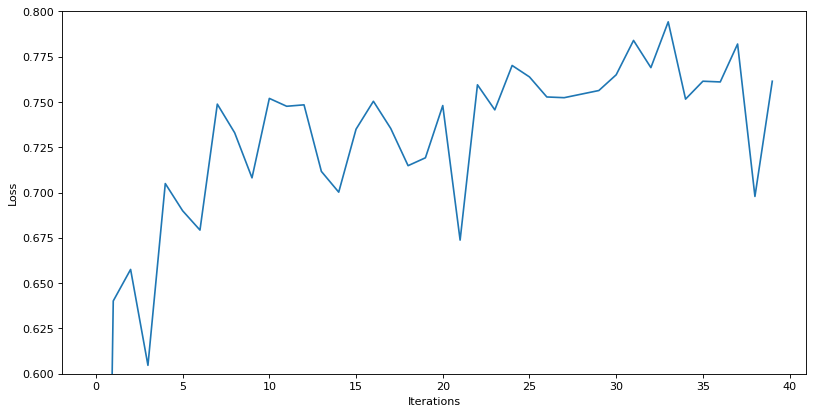

In [0]:

fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
x = np.array(range(len(model.acc_val)))
plt.plot(x, model.acc_val)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.ylim([0.6, 0.8])
plt.show()
